In [ ]:
from pathlib import Path
from lib.noise_sampler import generate_graphs

RULES_PATH = Path("lib/sampling_rules.json")
noise_graphs = generate_graphs(n=200, max_events=24, rules_json_path=RULES_PATH, seed=42)

In [ ]:
from lib.target_sampler import generate_target_graphs

target_graphs = generate_target_graphs()

In [ ]:
from lib.WL2vec import graph_to_fingerprint

noise_fingerprints = {str(i): graph_to_fingerprint(g) for i, g in enumerate(noise_graphs)}
target_fingerprints = {str(len(noise_graphs)+i): graph_to_fingerprint(g) for i, g in enumerate(target_graphs)}

In [ ]:
from lib.pinecone import upsert

upsert(fingerprints=noise_fingerprints)
upsert(fingerprints=target_fingerprints, metadata={ 'target': 'yes' })

In [19]:

from lib.pinecone import query

target_base_graph = "200"
results = query(target_fingerprints[target_base_graph], 10)

matches = results.matches


200
-----------


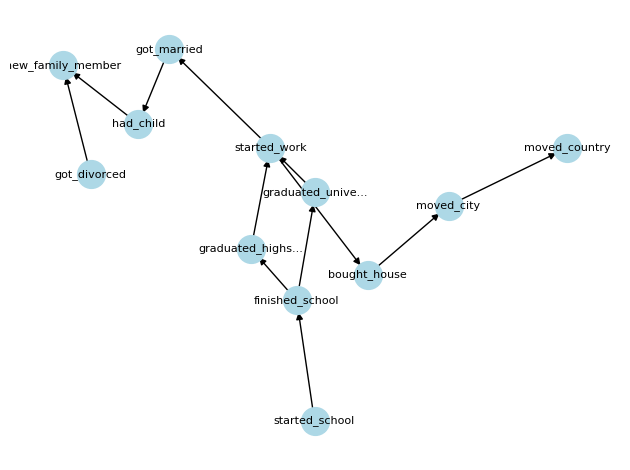

202
-----------


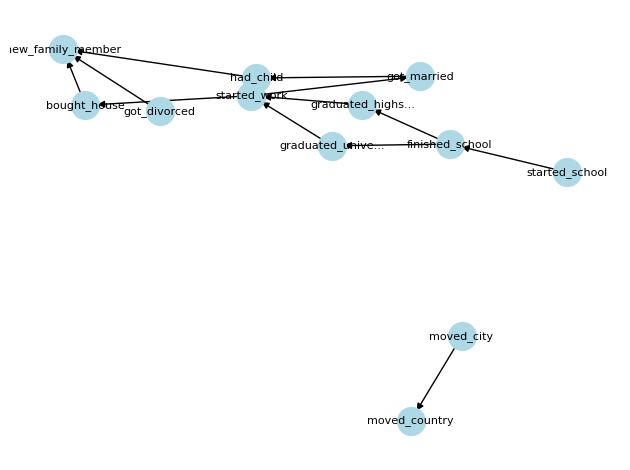

201
-----------


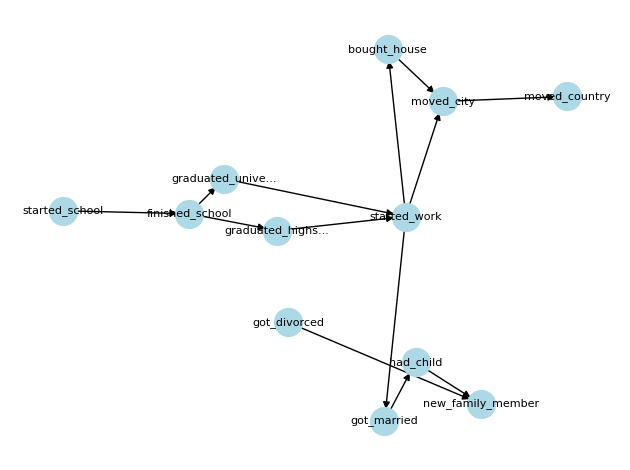

205
-----------


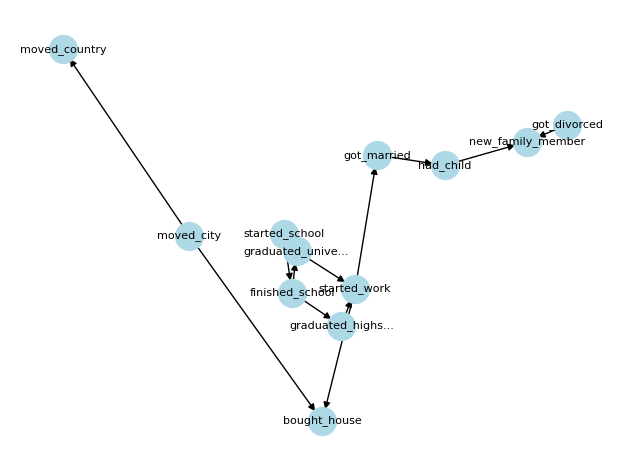

204
-----------


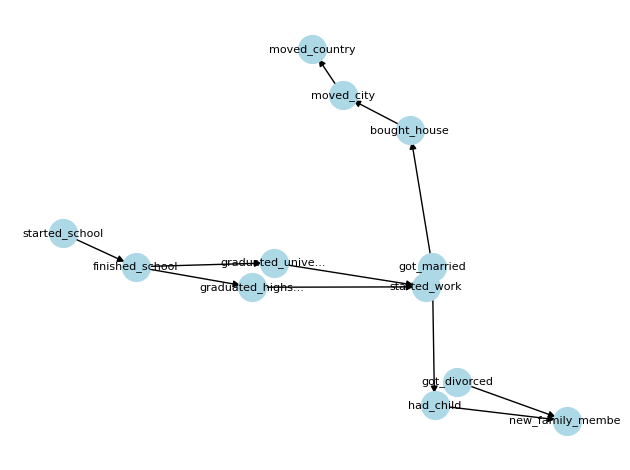

203
-----------


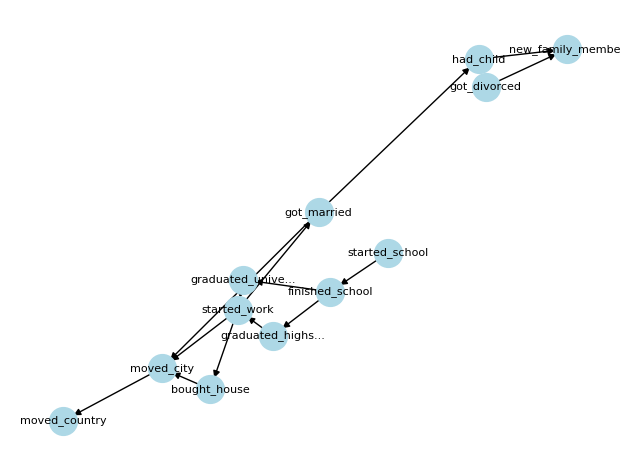

206
-----------


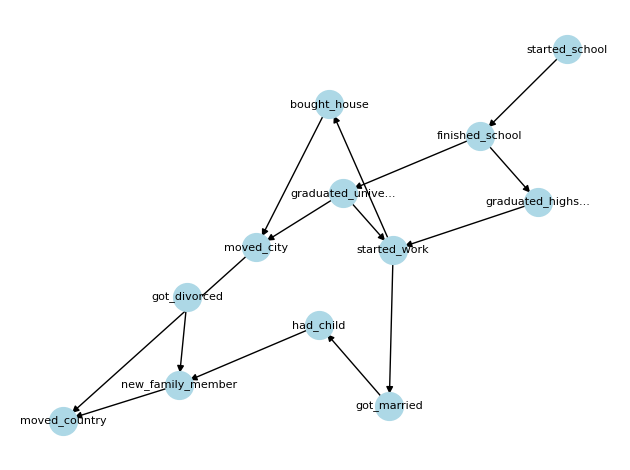

193
-----------


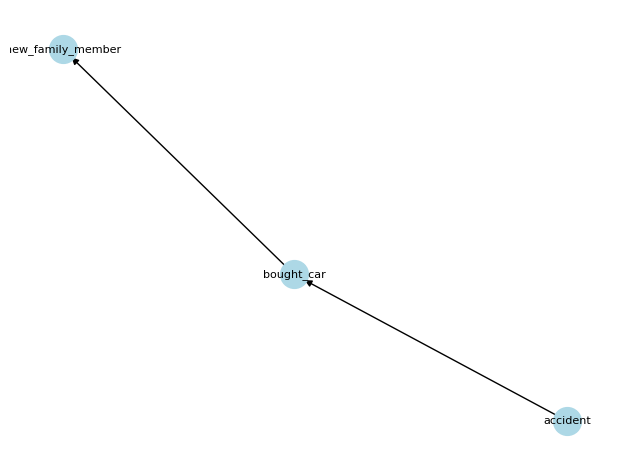

165
-----------


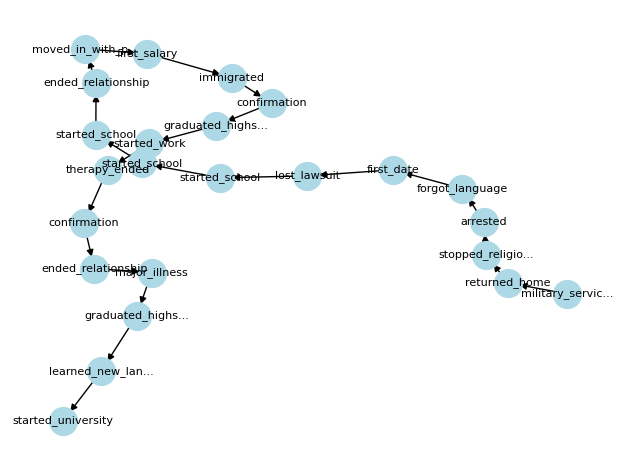

31
-----------


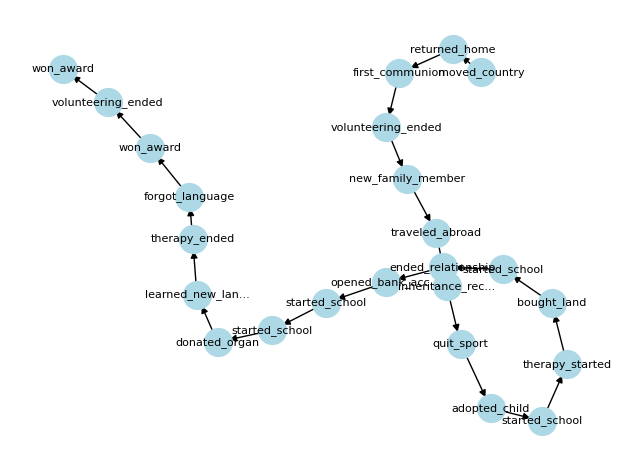

In [20]:
all_graphs = noise_graphs + target_graphs

for match in results.matches:
    print(match.id)
    print("-----------")
    all_graphs[int(match.id)].visualize()